In [341]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec


import matplotlib.cm as cm
import matplotlib.colors as mcolors

import seaborn as sns
import folium 
import json
import math
from math import radians, cos, sin, asin, sqrt
import itertools
import statistics as stats
from statistics import mean

import geopandas as gpd
from shapely.geometry import Point
from folium.plugins import HeatMap

import bokeh

print('All imported!')

All imported!


In [2]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row, column
from ipywidgets import interact
from bokeh.models import ColumnDataSource, FactorRange, Select, CustomJS
from bokeh.plotting import output_file, save, figure, show


output_notebook()

Loading BokehJS ...

In [328]:
# Set global font
plt.rcParams['font.family'] = 'Georgia'  # Use 'sans-serif', 'monospace', 'cursive', etc.
plt.rcParams['font.size'] = 10  # Adjust font size
plt.rcParams['font.weight'] = 'normal'  # Options: 'light', 'normal', 'bold'
print('Pretty :)')

Pretty :)


In [3]:
from folium import plugins

In [428]:
# Load and reproject shapefile
baanat_shp = gpd.read_file("/Users/maijavalimaki/Desktop/DTU_Social_data_course/helsinki data/baanat/baana_viivat.shp")
baanat_3879 = baanat_shp.set_crs(epsg=3879) 
baanat_4326 = baanat_3879.to_crs(epsg=4326)
baanat_geojson = baanat_4326.to_json()

# Optional: Save to GeoJSON for Folium or reuse
baanat_4326.to_file("baanat.geojson", driver="GeoJSON")


In [305]:
postal_codes_gdf = gpd.read_file("/Users/maijavalimaki/Desktop/DTU_Social_data_course/helsinki data/PKS_Postinumeroalueet_2024.shp")
postal_codes_gdf = postal_codes_gdf.to_crs(epsg=4326)
postal_codes_gdf = postal_codes_gdf.drop(columns = ['Postitoimi', 'PostitoiRU', 'NimiRU', 'Kunta_nro'])
postal_codes_gdf.columns = ['POSTAL CODE', 'NAME', 'CITY', 'geometry' ]

# Step 2: Save to GeoJSON (optional)
postal_codes_gdf.to_file("postal_codes.geojson", driver='GeoJSON')

In [306]:
postal_codes_gdf.head()

,POSTAL CODE,NAME,CITY,geometry
0,00100,Helsinki Keskusta - Etu-Töölö,Helsinki,"POLYGON ((24.91739 60.17664, 24.91766 60.17666..."
1,00120,Punavuori,Helsinki,"POLYGON ((24.94093 60.16721, 24.94107 60.16727..."
2,00130,Kaartinkaupunki,Helsinki,"POLYGON ((24.94193 60.16764, 24.95107 60.1679,..."
3,00140,Kaivopuisto - Ullanlinna,Helsinki,"POLYGON ((24.94835 60.16103, 24.94846 60.1603,..."
4,00150,Eira - Hernesaari,Helsinki,"POLYGON ((24.94545 60.15314, 24.94237 60.12659..."


In [310]:
df_accidents = pd.read_csv('HKI_traffic_accidents.csv', sep = ';')
df_accidents = df_accidents.dropna(subset=['ita_etrs', 'pohj_etrs'])

# Create geometry from ETRS coordinates
df_accidents['geometry'] = df_accidents.apply(
    lambda row: Point(float(row['ita_etrs']), float(row['pohj_etrs'])),
    axis=1
)

# Convert to GeoDataFrame and update coordinate system
gdf_accidents = gpd.GeoDataFrame(df_accidents, geometry='geometry', crs="EPSG:3879")
gdf_accidents_wgs84 = gdf_accidents.to_crs(epsg=4326)

#edit columns
gdf_accidents_wgs84 = gdf_accidents_wgs84.drop(columns = ['pohj_etrs', 'ita_etrs'])
gdf_accidents_wgs84.columns = ['TYPE', 'SEVERITY', 'YEAR', 'geometry']

#translating
translations = {
    'JK':'PEDESTRIAN', 
    'PP': 'BICYCLE',
    'MA':'MOTOR VEHICLE', 
    'MP': 'MOTOR CYCLE'
}
gdf_accidents_wgs84['TYPE'] = gdf_accidents_wgs84['TYPE'].replace(translations)

print('Traffic accident data has been saved as "df_accidents". Rows with incomplete location data has been removed.\nCoordinate system has been changed to wgs84. Accidents types have been translated.')

Traffic accident data has been saved as "df_accidents". Rows with incomplete location data has been removed.
Coordinate system has been changed to wgs84. Accidents types have been translated.


In [308]:
gdf_accidents_wgs84['TYPE'].unique()

array(['PEDESTRIAN', 'MOTOR VEHICLE', 'MOTOR CYCLE', 'BICYCLE'],
      dtype=object)

In [311]:
gdf_accidents_with_postal = gpd.sjoin(
    gdf_accidents_wgs84,
    postal_codes_gdf[['geometry', 'POSTAL CODE', 'NAME', 'CITY']],
    how='left',
    predicate='within'
)

gdf_accidents_with_postal.head()

,TYPE,SEVERITY,YEAR,geometry,index_right,POSTAL CODE,NAME,CITY
0,PEDESTRIAN,1,2022,POINT (25.02996 60.19489),65,00810,Herttoniemi,Helsinki
1,PEDESTRIAN,2,2022,POINT (25.0503 60.18363),68,00840,Laajasalo,Helsinki
2,PEDESTRIAN,2,2022,POINT (25.12339 60.22849),79,00950,Vartioharju,Helsinki
3,PEDESTRIAN,2,2022,POINT (24.9785 60.1905),42,00580,Verkkosaari,Helsinki
4,PEDESTRIAN,2,2022,POINT (24.91935 60.18713),14,00250,Taka-Töölö,Helsinki


In [317]:
postal_areas = gdf_accidents_with_postal['NAME'].unique()
print(f'{postal_areas}\n, there are {len(postal_areas)} areas in total')

['Herttoniemi' 'Laajasalo' 'Vartioharju' 'Verkkosaari' 'Taka-Töölö'
 'Itäkeskus-Marjaniemi' 'Puotinharju' 'Kallio' 'Puotila' 'Malmi'
 'Pukinmäki-Savela' 'Itä-Pasila' 'Kruununhaka' 'Viikki' 'Kontula - Vesala'
 'Helsinki Keskusta - Etu-Töölö' 'Kamppi - Ruoholahti' 'Maununneva'
 'Länsi-Pasila' 'Toukola-Vanhakaupunki' 'Länsi-Pakila'
 'Etu-Vallila - Alppila' 'Kalasatama' 'Lauttasaari' 'Munkkiniemi'
 'Kaivopuisto - Ullanlinna' 'Kaartinkaupunki' 'Suurmetsä' 'Tapanila'
 'Roihupellon teollisuusalue' 'Vallila' 'Metsälä-Etelä-Oulunkylä'
 'Kannelmäki' 'Punavuori' 'Munkkivuori-Niemenmäki' 'Sörnäinen'
 'Pohjois-Meilahti' 'Etelä-Haaga' 'Konala' 'Käpylä' 'Östersundom'
 'Myllypuro' 'Jakomäki - Alppikylä' 'Mellunmäki' 'Pohjois-Haaga'
 'Maunula-Suursuo' 'Pitäjänmäen teollisuusalue' 'Oulunkylä-Patola'
 'Eira - Hernesaari' 'Pihlajamäki' 'Tapaninvainio' 'Kivihaka' 'Roihuvuori'
 'Reimarla' 'Itä-Pakila' 'Etelä-Vuosaari' 'Puistola' 'Veräjämäki'
 'Keski-Töölö' 'Kuusisaari-Lehtisaari' 'Koskela-Helsinki' 'Lassila

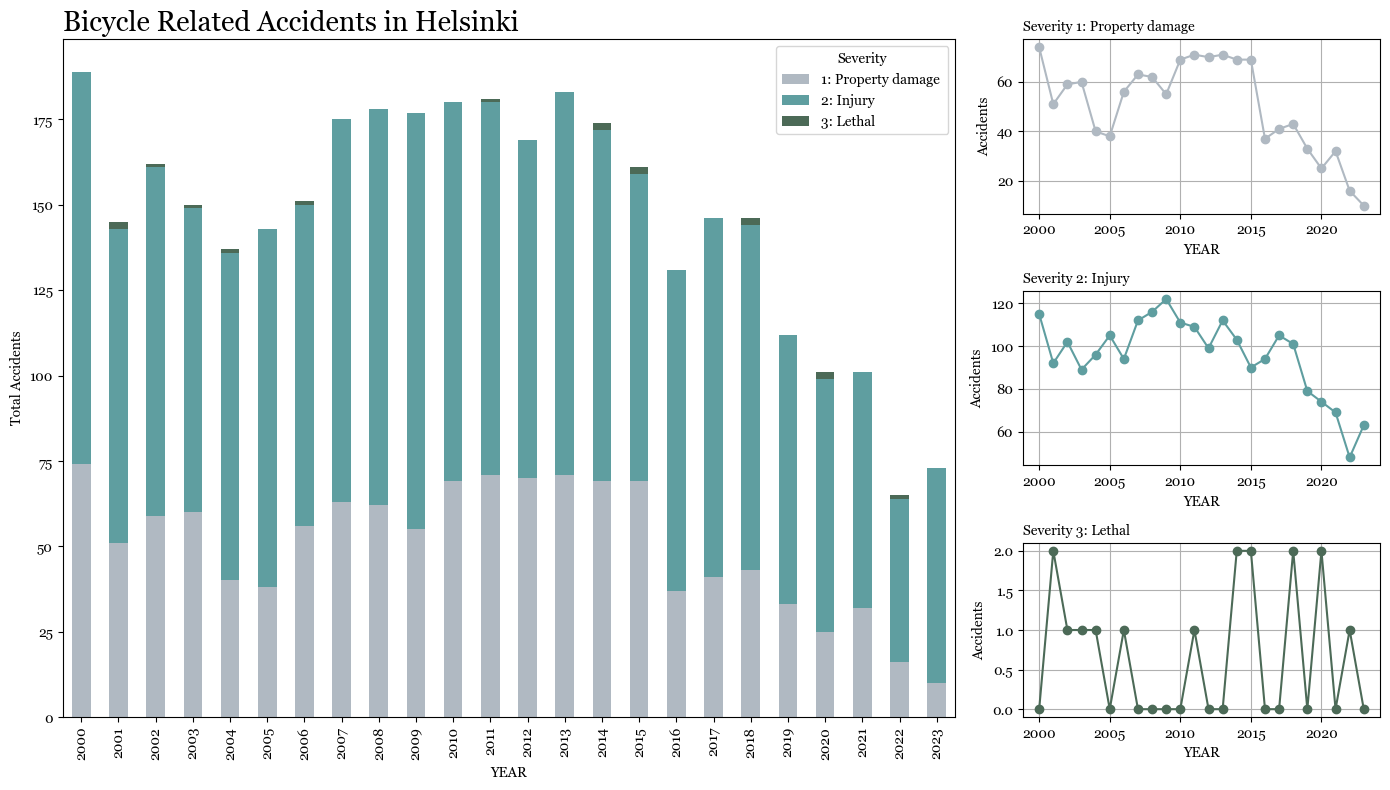

In [347]:
gdf_accidents_bike = gdf_accidents_with_postal[gdf_accidents_with_postal['TYPE']=='BICYCLE'].reset_index(drop=True)
gdf_accidents_bike.head()
accident_counts = gdf_accidents_bike.value_counts('YEAR').reset_index().sort_values(by='YEAR').reset_index(drop=True)
accident_counts.columns = ['YEAR', 'COUNT']
#plot = accident_counts.plot(x = 'YEAR', y= 'COUNT', kind = 'bar', legend = False, title = 'Bicycle related accidents in Helsinki', ylabel = 'accidents')

colors = ['#b0b9c2', '#5f9ea0', '#4c6a57']
accidents_summary = gdf_accidents_bike.groupby(['YEAR', 'SEVERITY']).size().unstack(fill_value = 0)
legend_labels=['1: Property damage ', '2: Injury', '3: Lethal']


#creating a layout
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(3, 2, width_ratios=[2.5, 1]) 

# --- Big stacked bar chart on the left ---
ax_main = fig.add_subplot(gs[:, 0])  # All 3 rows, column 0
accidents_summary.plot(
    kind='bar',
    stacked=True,
    ylabel = 'Accidents',
    legend = True,
    color = colors,
    ax = ax_main
)
ax_main.set_title('Bicycle Related Accidents in Helsinki', fontsize=20, loc='left', fontweight = 'normal')
ax_main.legend(title='Severity', labels=['1: Property damage ', '2: Injury', '3: Lethal'])
ax_main.set_ylabel('Total Accidents')

# --- Smaller line plots for each severity level on the right ---
for i, severity in enumerate([1, 2, 3]):
    ax = fig.add_subplot(gs[i, 1])
    accidents_summary[severity].plot(
        kind='line',
        marker='o',
        color=colors[i],
        ax=ax
    )
    ax.set_title(f"Severity {severity}: {legend_labels[i].split(': ')[1]}", fontsize=10, loc='left')
    ax.set_ylabel('Accidents')
    ax.grid(True)



plt.tight_layout()
plt.show()


[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


,TYPE,SEVERITY,YEAR,geometry,index_right,POSTAL CODE,NAME,CITY
0,BICYCLE,1,2022,POINT (24.98834 60.21955),40,00560,Toukola-Vanhakaupunki,Helsinki
1,BICYCLE,2,2022,POINT (24.92331 60.24753),51,00670,Paloheinä,Helsinki
2,BICYCLE,2,2022,POINT (24.88809 60.23918),31,00420,Kannelmäki,Helsinki
3,BICYCLE,2,2022,POINT (24.96211 60.19872),39,00550,Vallila,Helsinki
4,BICYCLE,2,2022,POINT (25.05786 60.21513),72,00880,Roihupellon teollisuusalue,Helsinki


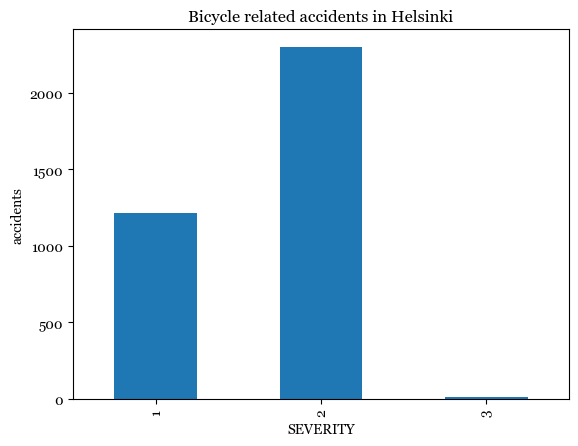

In [357]:
gdf_accidents_bike = gdf_accidents_with_postal[gdf_accidents_with_postal['TYPE']=='BICYCLE'].reset_index(drop=True)
gdf_accidents_bike.head()
accident_counts = gdf_accidents_bike.value_counts('SEVERITY').reset_index().sort_values(by='SEVERITY').reset_index(drop=True)
accident_counts.columns = ['SEVERITY', 'COUNT']
plot = accident_counts.plot(x = 'SEVERITY', y= 'COUNT', kind = 'bar', legend = False, title = 'Bicycle related accidents in Helsinki', ylabel = 'accidents')

years = list(range(2000, 2024))
print(years)
gdf_accidents_bike = gdf_accidents_bike[gdf_accidents_bike['YEAR'].isin(years)]
gdf_accidents_bike.head()

In [409]:
lethal = [3]
injury = [2]
property_damage = [1]

gdf_accidents_bike_severe = gdf_accidents_bike[gdf_accidents_bike['SEVERITY'].isin(lethal)]
len(gdf_accidents_bike_severe)

16

Text(0.5, 1.0, 'Bicycle related accidents in Helsinki since 2000 by postal area')

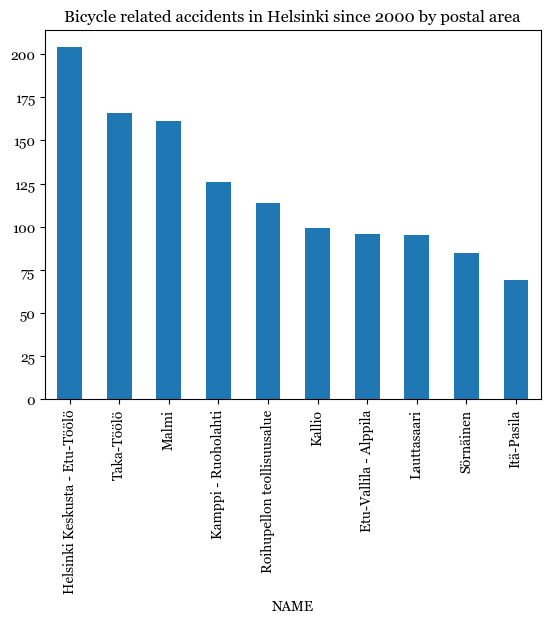

In [410]:
areal_counts = gdf_accidents_bike.value_counts('NAME').reset_index()
areal_counts_top10 = areal_counts[0:10]
top_10 = list(areal_counts_top10['NAME'])
top10_gdf = postal_codes_gdf[postal_codes_gdf['NAME'].isin(top_10)]
plot = areal_counts_top10.plot(x = 'NAME', y = 'count', kind = 'bar', legend = False)
plt.title('Bicycle related accidents in Helsinki since 2000 by postal area')

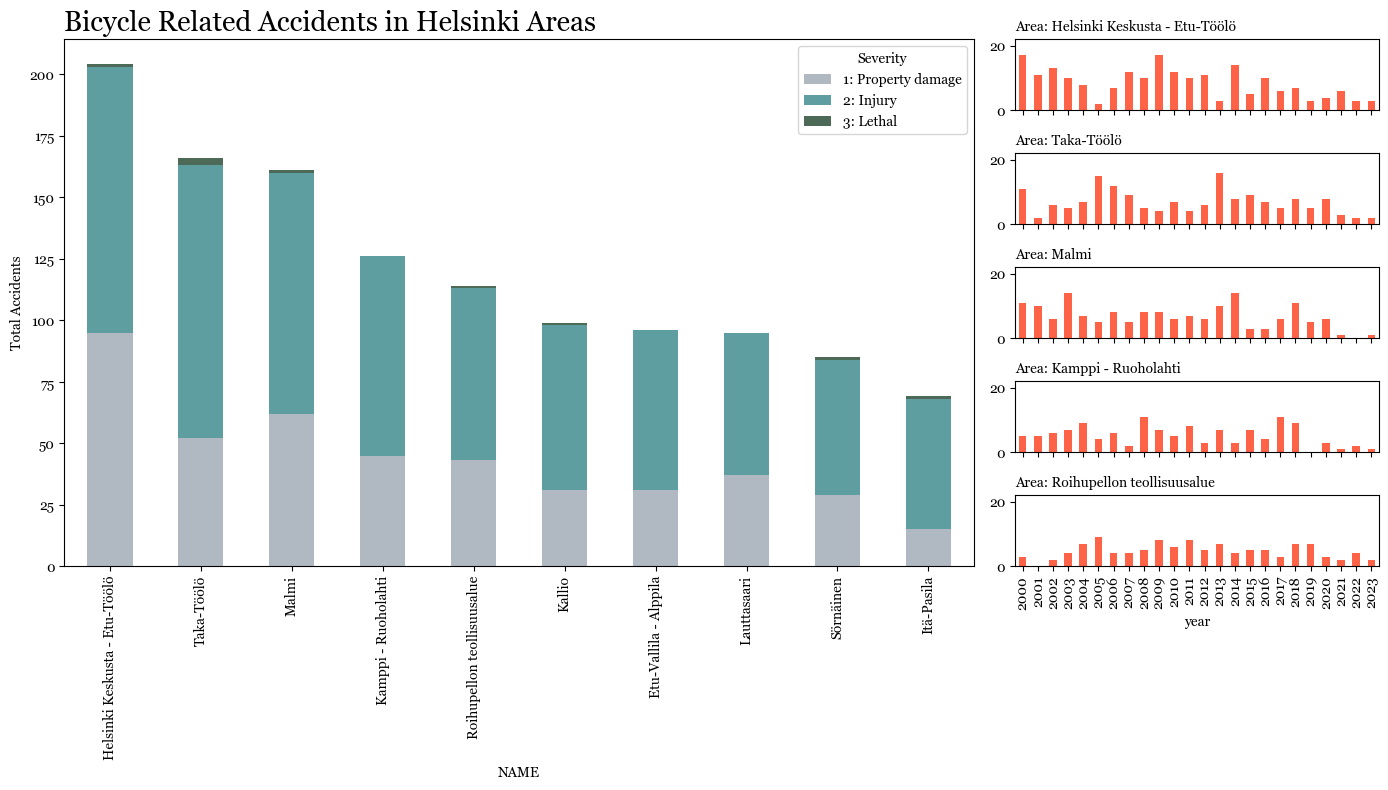

In [412]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Define colors
colors = ['#b0b9c2', '#5f9ea0', '#4c6a57']

# --- Accident summary by severity and area (for bar plot) ---
areal_accidents_summary = (
    gdf_accidents_bike
    .groupby(['SEVERITY', 'NAME'])
    .size()
    .unstack(fill_value=0)
)

# Sort areas by total accidents (descending)
sorted_areas = areal_accidents_summary.sum(axis=0).sort_values(ascending=False).index

# Get top 10 and top 5 area names
top_10 = sorted_areas[:10].tolist()
top_5 = sorted_areas[:5].tolist()

# Prepare data for plotting
summary_top10 = areal_accidents_summary[top_10].T  # rows = areas, columns = severity
summary_top5 = areal_accidents_summary[top_5].T

# --- Time series summary by year and area (for line plots) ---
area_year_summary = (
    gdf_accidents_bike
    .groupby(['YEAR', 'NAME'])
    .size()
    .unstack(fill_value=0)
)
shared_ymax = area_year_summary[top_5].max().max()

# --- Create layout ---
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(5, 2, width_ratios=[2.5, 1]) 

# --- Big stacked bar chart on the left ---
ax_main = fig.add_subplot(gs[:, 0])
summary_top10.plot(
    kind='bar',
    stacked=True,
    color=colors,
    ax=ax_main
)
ax_main.set_title('Bicycle Related Accidents in Helsinki Areas', fontsize=20, loc='left', fontweight='normal')
ax_main.legend(title='Severity', labels=['1: Property damage', '2: Injury', '3: Lethal'])
ax_main.set_ylabel('Total Accidents')
ax_main.set_xlabel('NAME')
ax_main.set_xticklabels(summary_top10.index, rotation=90)

# --- Yearly trends for top 5 areas on the right ---
for i, area in enumerate(top_5):
    ax = fig.add_subplot(gs[i, 1])
    area_year_summary[area].plot(
        kind='bar',
        ax=ax,
        color = 'tomato'
    )
    ax.set_title(f"Area: {area}", fontsize=10, loc='left')
    #ax.set_ylabel('Accidents')
    ax.set_ylim(0, shared_ymax + 5)
    ax.grid(False)
    if i < 4:
        ax.set_xticklabels([])  # Hide x-axis labels except for bottom plot
        ax.set_xlabel('')
    else:
        ax.set_xlabel('year')

plt.tight_layout()
plt.show()


In [417]:
gdf_accidents_bike_severe.head()

,TYPE,SEVERITY,YEAR,geometry,index_right,POSTAL CODE,NAME,CITY
29,BICYCLE,3,2022,POINT (25.11307 60.23219),81,00970,Mellunmäki,Helsinki
166,BICYCLE,3,2020,POINT (24.89469 60.19297),14,00250,Taka-Töölö,Helsinki
167,BICYCLE,3,2020,POINT (25.03619 60.19323),72,00880,Roihupellon teollisuusalue,Helsinki
379,BICYCLE,3,2018,POINT (24.96307 60.17902),37,00530,Kallio,Helsinki
380,BICYCLE,3,2018,POINT (24.87766 60.19173),22,00330,Munkkiniemi,Helsinki


In [430]:
#zooming to HKI
HKI_map = folium.Map([60.192059, 24.94584], zoom_start=12)
#SF City Hall:
folium.Marker([60.170278, 24.952222],
              popup='Helsingin tuomiokirkko',
              icon=folium.Icon(color='blue', icon='church',
                               prefix='fa')
             ).add_to(HKI_map)

style_function = lambda x: {
    'color': 'red',
    'weight': 3,
    'opacity': 0.8,
    'style': '-*-'
}

style_function_postal_codes = lambda x: {
    'color': 'black',
    'weight': 1,
    'opacity': 0.9,
    'fill': False
}


#accidents
gdf_accidents_bike_severe.loc[:,'lat'] = gdf_accidents_bike_severe.geometry.y
gdf_accidents_bike_severe.loc[:,'lon'] = gdf_accidents_bike_severe.geometry.x

#markers for lethal accidents 
for _, row in gdf_accidents_bike_severe.iterrows():
    folium.Marker(
        location = [row['lat'], row['lon']],
        icon=folium.Icon(color='black', icon='cross', prefix='fa'),
        fill=False,
        fill_opacity=0.7,
        popup=f"{row['TYPE']} – Severity: {row['SEVERITY']}, Year: {row['YEAR']}"
    ).add_to(HKI_map)

#heatmap
heat_data = [[row['lat'], row['lon']] for _, row in gdf_accidents_bike.iterrows()]

HeatMap(
    heat_data,
    min_opacity=0.8,
    radius = 5,
    blur=12,
    max_zoom=18
).add_to(HKI_map)

#main bike routes
folium.GeoJson(
    data=baanat_geojson,
    name="Baanat",
    style_function=style_function
).add_to(HKI_map)

#postal code areas
'''folium.GeoJson(
    data = postal_codes_gdf,
    name = 'Postal codes',
    style_function=style_function_postal_codes
    
).add_to(HKI_map)'''

HKI_map